In [1]:
from __future__ import division
import numpy as np
import pylab as plt
import swordfish as sf
from scipy.interpolate import interp1d
from scipy.constants import c
from numpy.random import multivariate_normal
from matplotlib import rc
from scipy.interpolate import UnivariateSpline
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
%matplotlib inline

c_kms = c*1.e-3 # in km s^-1
g2 = 1.e-18
sig0 = 1e-45
m_med = 1e5 # MeV
GeV_inv_cm = 1.98e-14
mp = 0.93

# Xenon1T

We can now implement the projected limits for Xenon1T based off 83 days of exposure using the same recoil energy spectrum as for CRESST-III but with the appropriate changes made for the Xenon nuclei (it is more simple here since there are only Xenon nuclei). We assume that there is only one isotope for our calculations. Since we do not have access to the Xenon background with much detail we perform a 1D analysis using the backgrounds published in 1705.06655 as a function of the S1 signal. We therefore need to to approximate the way that the dark matter signal is distributed between S1 and S2.

Now we define the signal component as,
$$ \frac{dR}{dE_R} = \frac{\rho_0\xi_T}{2\pi m_{DM}} \frac{g^2 F_T^2(E_{R})}{(2m_TE_{R} + m^2_{med})^2}\eta(v_{min}(E_R))$$

where $E_R$ is the recoil energy, $\rho_0$ is the dark matter density at earth (which we take to be $0.3 GeV cm^{-3}$, $m_{DM}$ is the dark matter mass, $m_{med}$ is the mediator mass, $F_T^2(E_{R})$ is the recoil form factor, and $m_T$ is the mass of the target isotope.

In [2]:
rho_0 = 0.3*1.e3  # MeV/cm3
# Define energy range in MeV

def eta_F():
    """Returns an interpolated integral over the velocity distribution, taken to be Maxwellian"""
    v, gave = np.loadtxt("DD_files/gave.dat", unpack=True, dtype=float)
    f = interp1d(v, gave, bounds_error=False, fill_value=0.0) # s km^-1
    return f

def dRdE(E_R, m_DM, A, xi_T):
    """Return differential recoil rate in 1/s/MeV/kg."""
    # g is the parameter we wish to set a limit on so is left out
    # Form factor taken from eq4.4 of http://pa.brown.edu/articles/Lewin_Smith_DM_Review.pdf
    m_T = A*931.5 # MeV
    muT = m_DM*m_T/(m_DM + m_T) # unitless
    rn = A**(1./3.) * 1/197. # fm --> MeV^-1
    F_T = lambda q: np.sqrt(np.exp(-((q*rn)**2.)/3.))
    vmin = lambda E_R: np.sqrt(m_T*E_R/2/(muT**2.))
    eta = eta_F()
    q = np.sqrt(2*m_T*E_R)
    signal = (A**2)*F_T(q)**2*eta(vmin(E_R)*c_kms)*rho_0*xi_T*g2/2./np.pi/m_DM/((q**2+m_med**2)**2)
    conversion = 1.96311325e24 # MeV^-4 cm^-3 s km^-1 hbar^2 c^6 --> MeV^-1 s^-1 kg^-1
    signal *= conversion 
    return signal

In [3]:
eff1, eff2 = np.loadtxt("Swordfish_Xenon1T/Efficiency-1705.06655.txt", unpack=True)
efficiency = UnivariateSpline(eff1, eff2, ext="zeros", k=1, s=0)
S1_vals, E_vals = np.loadtxt("Swordfish_Xenon1T/S1vsER.txt", unpack=True)

# Interpolation for the recoil energy as a function of S1
# and the derivative
CalcER = UnivariateSpline(S1_vals, E_vals, k=4, s=0)
dERdS1 = CalcER.derivative()

# Recoil distribution as a function of S1
# taking into account the efficiency and change
# of variables ER -> S1
def dRdS1(S1, m_DM):
    A_Xe = 131. #FIXME: Change to Xenon values
    xi_T_Xe = 1.0
    ER_keV = CalcER(S1)
    ER_MeV = ER_keV*1.e-3
    #Factor of 0.475 comes from the fact that
    #the reference region should contain about
    #47.5% of nuclear recoils (between median and 2sigma lines)
    # Factor of 1/1e3 to convert 1/MeV --> 1/keV
    return 0.475*efficiency(ER_keV)*dRdE(ER_MeV,m_DM,A_Xe,xi_T_Xe)/1e3*dERdS1(S1)

In [4]:
# We are now working in distributions as a function of s1
s1 = np.linspace(3,70,num=100)
s1width = s1[1]-s1[0]
s1means = s1[0:-1]+s1width/2.
bkgs = ['acc','Anom','ElectronRecoil','n','Neutrino','Wall']

def load_bkgs():
    b = dict()
    for i in range(len(bkgs)):
        S1, temp = np.loadtxt("DD_files/" + bkgs[i] + ".txt", unpack=True)
        interp = interp1d(S1, temp, bounds_error=False, fill_value=0.0)
        b[bkgs[i]] = interp(s1means)
    return b
    
def XenonIT_sig(m_DM):
    m_DM *= 1.e3 # conversion to MeV
    sig = dRdS1(s1means,m_DM)*s1width
    return sig

In [5]:
b_dict = load_bkgs()
obsT = np.ones_like(s1means)*24.*3600.*35636.
mlist = np.logspace(1, 3, 50) # GeV
b = np.array(b_dict[bkgs[0]]/obsT)
K = np.diag((b.flatten()*0.01)**2)
B = [b_dict[bkgs[0]]/obsT, b_dict[bkgs[1]]/obsT, b_dict[bkgs[2]]/obsT,
    b_dict[bkgs[3]]/obsT, b_dict[bkgs[4]]/obsT, b_dict[bkgs[5]]/obsT]

def g(m, sigma):
    # Takes in sigma and returns g^2
    mu_temp = m*mp/(m+mp)
    return np.ones_like(s1means)*np.pi*((m_med/1.e3)**4.)*sigma/(GeV_inv_cm**2.)/(mu_temp**2.)

SF = sf.Swordfish(B, T=[0.1,0.1,0.1,0.1,0.1,0.1], E=obsT, K=K)
ULlist_Xenon = []
DRlist_Xenon = []
for i, m in enumerate(mlist):
    sig = XenonIT_sig(m)
    UL = SF.upperlimit(sig, 0.05)
    DR = SF.discoveryreach(sig, 2.87e-7)
    DRlist_Xenon.append(DR*g2)
    ULlist_Xenon.append(UL*g2)
    
mu_xp = mlist*mp/(mlist+mp)
sigma_Xe = (GeV_inv_cm**2.)*np.array(ULlist_Xenon)*mu_xp**2./np.pi/(m_med/1.e3)**4.
sigma_Xe_DR = (GeV_inv_cm**2.)*np.array(DRlist_Xenon)*mu_xp**2./np.pi/(m_med/1.e3)**4.

In [6]:
m10list = np.linspace(1, 3, 50) # GeV
s10list = np.linspace(-46, -44, 50)

S = lambda m, sigma: g(10**m, 10**sigma)*(g2**(-1))*XenonIT_sig(10**m)
print S(1.7, -46).sum()*3600.*24*35636
TF = SF.getfield(S, m10list, s10list)
vf1, vf2 = TF.VectorFields()

0.83096555216


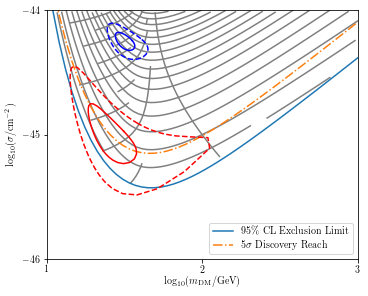

In [9]:
plt.figure(figsize=(5,4))
mask = lambda x, y: (y > np.interp(x, np.log10(mlist), np.log10(sigma_Xe))) & (y<-44)
vf1.streamlines(color='0.5', mask = mask, Nmax = 40);
vf2.streamlines(color='0.5', mask = mask, Nmax = 40);

plt.plot(np.log10(mlist), np.log10(sigma_Xe), label=r"95\% CL Exclusion Limit")
plt.plot(np.log10(mlist), np.log10(sigma_Xe_DR), "-.", label=r"$5\sigma$ Discovery Reach")

TF.contour([1.4, -45.], 1., color='r', ls='-');
TF.contour([1.4, -45.], 2., color='r', ls='--');
TF.contour([1.5, -44.25], 1., color='b', ls='-');
TF.contour([1.5, -44.25], 2., color='b', ls='--');

plt.legend(loc=4)
y = [-46,-45,-44]
x = [1,2,3]
plt.xlim(1.,3.)
plt.ylim(-46,-44)
plt.xlabel(r"$\log_{10}(m_{\mathrm{DM}}/\rm GeV)$")
plt.ylabel(r"$\log_{10}(\sigma /\rm cm^{-2})$")
plt.yticks(np.arange(min(y), max(y)+1, 1.0))
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.tight_layout(pad=0.3)
plt.savefig("Xe_stream_limits.eps")